In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import neural_network
from sklearn.model_selection import train_test_split, KFold
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from sklearn.metrics import confusion_matrix,  roc_curve, auc, precision_score, recall_score, f1_score



In [18]:
healthy_data = pd.read_csv('/content/drive/MyDrive/Spl topics in AI/Project/processed_results2_hc.csv')
pd_data = pd.read_csv("/content/drive/MyDrive/Spl topics in AI/Project/processed_results2_pd.csv")

healthy_data['label'] = 0
pd_data['label'] = 1

frames = [healthy_data, pd_data]
df = pd.concat(frames)

df = df.drop('voiceID', axis = 1)

In [10]:
df.head(5)

,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,...,JitterPCA,ShimmerPCA,pF,fdisp,avgFormant,mff,fitch_vtl,delta_f,vtl_delta_f,label
0,151.114717,173.028992,26.042716,13.292053,0.026783,0.000155,0.011867,0.013015,0.035600,0.111533,...,4.254054,1.280083,1.291001,1157.083600,2284.521944,1766.874568,15.931988,1144.678590,15.288134,0
1,164.105057,188.803016,29.907306,11.243993,0.015988,0.000085,0.006635,0.006978,0.019906,0.078234,...,-3.150761,0.125995,-0.026432,1163.750228,2177.035048,1632.324771,17.340182,1105.268318,15.833259,0
2,139.555329,123.982623,23.363294,13.423983,0.026935,0.000218,0.010964,0.011671,0.032892,0.102448,...,3.047446,0.350653,-1.620569,970.327341,1943.058079,1505.488526,18.669511,975.273285,17.943688,0
3,110.926916,180.520417,34.073202,12.235210,0.020818,0.000115,0.008991,0.009034,0.026972,0.080520,...,-1.665359,-0.676599,0.393018,1142.179360,2188.402499,1712.549717,16.371879,1103.799364,15.854331,0
4,146.104762,194.261126,37.678373,14.669165,0.015138,0.000078,0.005401,0.005984,0.016203,0.082313,...,-2.736372,1.659618,0.491228,1075.329006,2162.857357,1724.897066,16.242818,1079.213418,16.215514,0


In [11]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

<ipython-input-11-5ed635d377bc>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df.drop(['label'], 1))


In [12]:
pca = PCA(n_components=20)
decomposed_data = pca.fit_transform(X)

In [13]:
decomposed_data.shape

(37, 20)

In [14]:
nn = neural_network.MLPClassifier(
                                   hidden_layer_sizes = (200), 
                                   random_state = 42)

In [15]:
cv = KFold(n_splits=5)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-19-11ca6bdfb44b>:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.

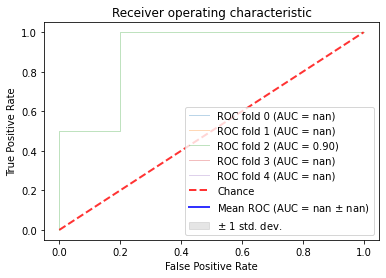

17,4,80.9524
6,10,62.5
73.913,71.4286,0


Accuracy: 36.43% +- 37.43%
Recall:  0.35714285714285715
Precision:  0.6
F1-score:  0.4454545454545455


In [19]:
#MLP with PCA

folds = 10
acc_pca = np.zeros(folds)
confm = np.zeros((2, 2))
prec_pca = []
rec_pca = []
f1_pca = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X = decomposed_data
i = 0
for train, test in cv.split(X, y):
    probas_ = nn.fit(X[train], y[train]).predict_proba(X[test])
    # print(np.asarray(y[test], dtype=int))
    # Compute accuracy
    y_pred = nn.predict(X[test])
    acc_pca[i] = (y_pred == y[test]).mean()
    #Compute precision 
    prec_pca.append(precision_score(y[test], y_pred).mean())
    #Compute recall
    rec_pca.append(recall_score(y[test], y_pred).mean())
    #Compute f1-score
    f1_pca.append(f1_score(y[test], y_pred).mean())
    # Confusion matrix
    confm = confm + confusion_matrix(y[test], y_pred)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(np.array(y[test], dtype=int), probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.rcParams["figure.figsize"] = (6,10)
plt.show()
'{:.2f}% +- {:.2f}%'.format(acc_pca.mean() * 100, acc_pca.std() * 100) 
cm = np.zeros((3,3))
cm[0:2, 0:2] = confm
cm[0,2] = (cm[0,0] / cm[0,0:2].sum())* 100
cm[1,2] = (cm[1,1] / cm[1,0:2].sum())* 100
cm[2,0] = (cm[0,0] / cm[0:2,0].sum())* 100
cm[2,1] = (cm[1,1] / cm[0:2,1].sum())* 100
display(HTML(tabulate.tabulate(cm, tablefmt='html')))

print('Accuracy: {:.2f}% +- {:.2f}%'.format(acc_pca.mean() * 100, acc_pca.std() * 100) )
print('Recall: ', sum(rec_pca)/len(rec_pca))
print('Precision: ', sum(prec_pca)/len(prec_pca))
print('F1-score: ', sum(f1_pca)/len(f1_pca))

<ipython-input-21-f064fadaf700>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df.drop(['label'], 1))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to contr

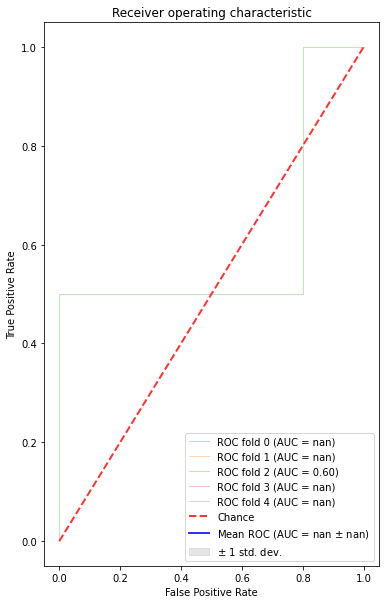

Confusion Matrix: 


20,17,54.0541
25,23,47.9167
44.4444,57.5,0


Accuracy: 35.71% +- 42.02%
Recall:  0.27142857142857146
Precision:  0.5
F1-score:  0.31666666666666665


In [21]:
#MLP without PCA

folds = 10
acc = np.zeros(folds)
confm = np.zeros((2, 2))
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])
tprs = []
aucs = []
prec = []
rec = []
f1 = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    probas_ = nn.fit(X[train], y[train]).predict_proba(X[test])
    # print(np.asarray(y[test], dtype=int))
    # Compute accuracy
    y_pred = nn.predict(X[test])
    acc[i] = (y_pred == y[test]).mean()
    #Compute precision 
    prec.append(precision_score(y[test], y_pred).mean())
    #Compute recall
    rec.append(recall_score(y[test], y_pred).mean())
    #Compute f1-score
    f1.append(f1_score(y[test], y_pred).mean())
    # Confusion matrix
    confm = confm + confusion_matrix(y[test], y_pred)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(np.array(y[test], dtype=int), probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
'{:.2f}% +- {:.2f}%'.format(acc.mean() * 100, acc.std() * 100) 
cm = np.zeros((3,3))
cm[0:2, 0:2] = confm
cm[0,2] = (cm[0,0] / cm[0,0:2].sum())* 100
cm[1,2] = (cm[1,1] / cm[1,0:2].sum())* 100
cm[2,0] = (cm[0,0] / cm[0:2,0].sum())* 100
cm[2,1] = (cm[1,1] / cm[0:2,1].sum())* 100
print("Confusion Matrix: ")
display(HTML(tabulate.tabulate(cm, tablefmt='html')))

print('Accuracy: {:.2f}% +- {:.2f}%'.format(acc.mean() * 100, acc.std() * 100) )
print('Recall: ', sum(rec)/len(rec))
print('Precision: ', sum(prec)/len(prec))
print('F1-score: ', sum(f1)/len(f1))

In [22]:
import tensorflow as tf

from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

In [23]:
X = df.copy()
y = X.pop('label') # pop last column off from X 

# normalise X so all features are within similar range
preprocessor = make_column_transformer((StandardScaler(),list(X.columns)))

# split into training, cross validation set
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.6) #stratify makes sure classes are represented evenly across splits

# split cross validation set into cross val and test set
X_valid, X_test, y_valid, y_test = \
    train_test_split(X_valid, y_valid, stratify=y_valid, train_size=0.8)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)


In [24]:
input_dim = [X_train.shape[1]]  # Number of features


In [25]:
model = tf.keras.Sequential([
    layers.Dense(70,activation="relu",input_shape=input_dim), # hidden layer 1 with 70 nodes and relu activation fnc
    layers.BatchNormalization(), # normalize hidden layer --> more stability
    layers.Dropout(0.1), # randomly drop 10% of nodes to prevent overfitting
    layers.Dense(70,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(40,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(30,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(1,activation="sigmoid") # binary output so only 1 output node, activation function is sigmoid
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["binary_accuracy", "Precision", "Recall"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                3220      
                                                                 
 batch_normalization (BatchN  (None, 70)               280       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 batch_normalization_1 (Batc  (None, 70)               280       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 70)                0

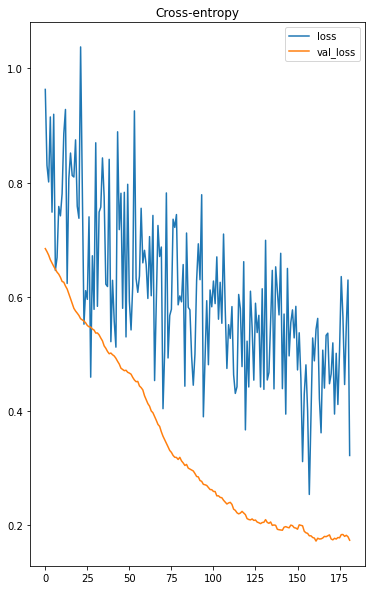

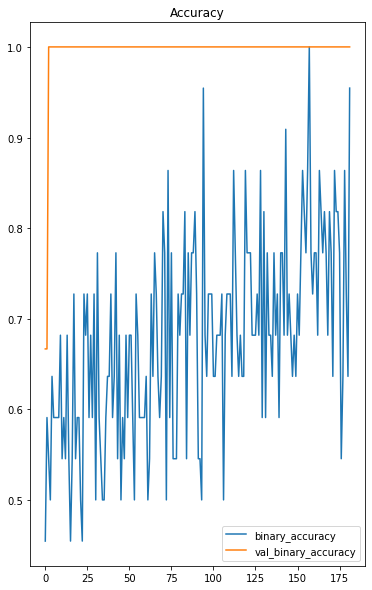

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=10,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [28]:
loss, accuracy, precision, recall = model.evaluate(X_train, y_train, verbose=False)
f1_sc = (precision*recall)/(precision+recall)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Precision: {:.4f}".format(precision))
print("Training Recall: {:.4f}".format(recall))
print("Training F1-score: {:.4f}".format(f1_sc))
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=False)
f1_sc = (precision*recall)/(precision+recall)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Precision: {:.4f}".format(precision))
print("Training Recall: {:.4f}".format(recall))
print("Testing F1-score: {:.4f}".format(f1_sc))

Training Accuracy: 0.8182
Training Precision: 0.8000
Training Recall: 0.8000
Training F1-score: 0.4000
Testing Accuracy:  1.0000
Testing Precision: 1.0000
Training Recall: 1.0000
Testing F1-score: 0.5000


In [29]:
predictions = [round(x[0]) for x in model.predict(X_test)]
y = [x for x in y_test]
num_true = 0
total = len(predictions)
for i in range(len(predictions)):
    if predictions[i] == y[i]:
        num_true += 1
accuracy = (num_true/total)*100

print("Percent of correct predictions: {}%".format(accuracy))

1/1 [==============================] - 0s 175ms/step
Percent of correct predictions: 100.0%
